<a href="https://colab.research.google.com/github/griffin-leonard/ML-Classifiers-for-Argumentation-Teaching-Strategies/blob/main/elk_argumentation_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [31]:
!pip install datasets

import datasets # for Dataset (formatting for tokenizer)
import pandas as pd # for dataframes (loading data from csv files)
import pyarrow as pa # for Tables (input to Dataset)
import torch.nn as nn
import torch

### Load and preprocess data

1. Load data from CSV
2. Remove student lines

In [32]:
FILENAME = 'elk_data.csv' # csv file containing dataset
df = pd.read_csv(FILENAME, header=0)

#remove student lines from the dataset
for i, role in enumerate(df['role']):
    if role == 'Student':
        df = df.drop(index=i)
df = df.reset_index()

### Format data for tokenization

1. Reduce data to lines and labels for training and testing
  *   Seperate press for reasoning into general and 
      specific (binary categories
  *   Make revoicing binary

2. Seperate into training and testing sets
3. Format for tokenizer: Dataset objects inside a DataDict object

In [60]:
large_dict = dict()
_LABELS_IN = ['Priming - G', 'Eliciting - G', 'Probing - G', 'Evaluating - G', 'Telling - G', 'NA - G', 'Yes/no question - G', 'Argumentation words - G', 'Connection to bigger picture - G', 'You focused question - G', 'Funneling - G', 'Press for reasoning (G, S) - G', 'Revoicing (R, RP) - G']
_LABELS_PRESS = 'Press for reasoning (G, S) - G' # will be split into general and specific
ID2LABEL = {0:'Priming', 1:'Eliciting', 2:'Probing', 3:'Evaluating', 4:'Telling', 5:'NA', 6:'Yes/no question', 7:'Argumentation words', 8:'Connection to bigger picture', 9:'You focused question', 10:'Funneling', 11:'Revoicing', 12:'General press for reasoning', 13:'Specific press for reasoning'}
_LABELS_OUT = ID2LABEL.values()

#add the category labels for each line to a dictionary (including seperating press for reasoning and making revoicing binary)
for i, row in df.iterrows():
    labels = []
    for label in _LABELS_IN:
      #all other labels
      if label != _LABELS_PRESS:
        #general press for reasoning
        # R and RP to handle revoicing
        l = 1 if row[label]==1 or row[label]=='R' or row[label]=='RP' else 0
        labels.append(l)

      #press for reasoning
      else:
        if row[label]=='G': labels.append(1)
        else: labels.append(0)
        #specific press for reasoning
        if row[label]=='S': labels.append(1)
        else: labels.append(0)

    large_dict[i] = (row["line"], labels)


#split data into two dictionaries (training and testing)
size = len(large_dict.keys())
TEST_SIZE = .2 #portion of data used as test set
train, test = {}, {}
for i, tup in large_dict.items():
  if i <= size//(1/TEST_SIZE):
    test[i] = tup
  else: train[i] = tup
# train, test = train_test_split(large_dict, test_size=0.2) # UNUSED

schema = pa.schema({"line" : pa.string(), "label" : pa.list_(pa.uint8()) })

#training data
keys, val1, val2 = [], [], []
for k, (v1, v2) in train.items():
  keys.append(k)
  val1.append(v1)
  val2.append(v2)

d = dict(zip(schema.names, (val1, val2)))
table = pa.Table.from_pydict(d, schema=schema)
train_data = datasets.Dataset(table)

#testing data
keys, val1, val2 = [], [], []
for k, (v1, v2) in test.items():
  keys.append(k)
  val1.append(v1)
  val2.append(v2)

d = dict(zip(schema.names, (val1, val2)))
table = pa.Table.from_pydict(d, schema=schema)
test_data = datasets.Dataset(table)

raw_dataset = datasets.DatasetDict({"train":train_data, "test":test_data})
print(raw_dataset)

DatasetDict({
    train: Dataset({
        features: ['line', 'label'],
        num_rows: 700
    })
    test: Dataset({
        features: ['line', 'label'],
        num_rows: 176
    })
})


In [34]:
!pip install transformers
!pip install sentencepiece

from transformers import AutoTokenizer # tokenizing data
from transformers import AutoModelForSequenceClassification # loading pre-trained model
from transformers import Trainer # training on our data
from transformers import TrainingArguments # tuning pre-trained model
import numpy as np # math operations
from datasets import load_metric # evaluating model

### Tokenize data

In [35]:
# Get tokenizer for pre-trained model from BERT (can fine-tune later)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

def tokenize_function(examples):
  return tokenizer(examples["line"], padding="max_length", truncation=True)

tokenized_datasets = raw_dataset.map(tokenize_function, batched=True)

full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

print(full_train_dataset)

https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmplxysbosa


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
creating metadata file for /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
https://huggingface.co/bert-base-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpbzgb6eb1


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
creating metadata file for /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
creating metadata file for /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_7wi4wha


Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
creating metadata file for /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingfac

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['line', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 700
})


# Train and Evaluate model

In [61]:
NUM_CATEGORIES = 14 #number of binary categories being classified
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", problem_type="multi_label_classification", num_labels=NUM_CATEGORIES)
# model.config.id2label = ID2LABEL
training_args = TrainingArguments("test_trainer")
metric = load_metric("accuracy")

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 1

### Functions for evaluation metrics

In [37]:
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

THRESHOLD = 0.5 # cutoff for whether a prediction is 0 or 1

def accuracy_thresh(y_pred, y_true, thresh=THRESHOLD, sigmoid=False): 
    # gets overall classifier accuracy
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true) 
    if sigmoid: 
      y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true.bool()).float().mean().item()

def stats_report(y_pred, y_true, labels=_LABELS_OUT): 
    # gets f1 scores, precision, and recall for each category
    y_pred = np.around(1/(1 + np.exp(-y_pred)))
    return sklearn.metrics.classification_report(y_true, y_pred, target_names=labels)

def classwise_accuracy(y_pred, y_true, thresh=THRESHOLD, sigmoid=True): 
    # gets accuracy by category
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true) 
    if sigmoid: 
      y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true.bool()).float().mean(dim=0).tolist()

def correlation_matrix(y_true, thresh=THRESHOLD, labels=_LABELS_OUT):
    # displays a correlation matrix for the 14 categories
    df = pd.DataFrame(y_true, columns=labels)
    correlation_mat = df.corr()
    sn.heatmap(correlation_mat, annot = True)
    plt.title("Correlation matrix of Argumentation Questioning Strategies") 
    plt.show()

def compute_metrics(eval_pred, show_corr=True):
    # called by Trainer to evaluate model
    predictions, labels = eval_pred
    metrics = {'accuracy_thresh': accuracy_thresh(predictions, labels),
            'classwise_accuracy': classwise_accuracy(predictions, labels),
            'stats_report': stats_report(predictions, labels),
            'corr_matrix': correlation_matrix(labels)}
    return metrics

### Create model trainer

In [38]:
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

trainer = MultilabelTrainer(
    model=model,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_eval_dataset,
    compute_metrics=compute_metrics,
)

### Evaluate and train

Warning: Model takes around 3.5 hours to train!

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: line. If line are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 700
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 264


Step,Training Loss


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: line. If line are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 176
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


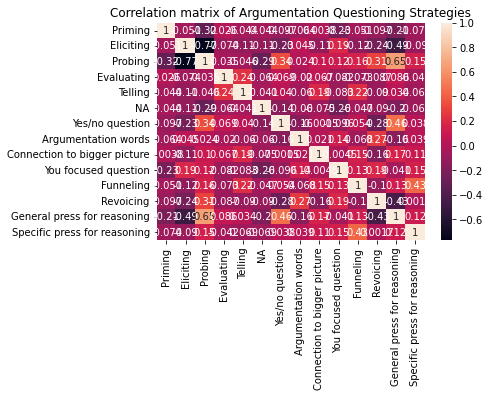

Trainer is attempting to log a value of "[0.9545454382896423, 0.8522727489471436, 0.8920454382896423, 0.9204545617103577, 0.9602272510528564, 0.9829545617103577, 0.7556818127632141, 0.9261363744735718, 0.8806818127632141, 0.9431818127632141, 0.9488636255264282, 0.8920454382896423, 0.8238636255264282, 0.8977272510528564]" of type <class 'list'> for key "eval/classwise_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "                              precision    recall  f1-score   support

                     Priming       0.00      0.00      0.00         8
                   Eliciting       0.76      0.49      0.59        39
                     Probing       0.90      0.95      0.92       119
                  Evaluating       1.00      0.12      0.22        16
                     Telling       0.00      0.00      0.00         7
                          NA       1.00      0.57

{'epoch': 3.0,
 'eval_accuracy_thresh': 0.8908278942108154,
 'eval_classwise_accuracy': [0.9545454382896423,
  0.8522727489471436,
  0.8920454382896423,
  0.9204545617103577,
  0.9602272510528564,
  0.9829545617103577,
  0.7556818127632141,
  0.9261363744735718,
  0.8806818127632141,
  0.9431818127632141,
  0.9488636255264282,
  0.8920454382896423,
  0.8238636255264282,
  0.8977272510528564],
 'eval_corr_matrix': None,
 'eval_loss': 0.26962578296661377,
 'eval_runtime': 332.2786,
 'eval_samples_per_second': 0.53,
 'eval_stats_report': '                              precision    recall  f1-score   support\n\n                     Priming       0.00      0.00      0.00         8\n                   Eliciting       0.76      0.49      0.59        39\n                     Probing       0.90      0.95      0.92       119\n                  Evaluating       1.00      0.12      0.22        16\n                     Telling       0.00      0.00      0.00         7\n                          NA  

In [31]:
trainer.train()
trainer.evaluate()

###Save model

Should output two bin files and a config file

In [33]:
trainer.save_model(output_dir='./')

Saving model checkpoint to ./
Configuration saved in ./config.json
Model weights saved in ./pytorch_model.bin


#Load Model

1. Put config.json and pytorch_model.bin in a folder called model

To Re-evaluate model:
  2. Run all of the code above except the Evaluate and train and Save model sections

  3. Run the code in the Re-Evaluate Model

To train on new data:
  2. Put csv file with ELK data in directory 

  3. Make sure the filename matches in the Load and preprocess data section

  4. Run all code blocks in the Preprocessing section then run the code in the Predictions on New Data section

In [ ]:
!pip install transformers

In [5]:
from transformers import AutoModelForSequenceClassification 

MODEL_DIR = './model' # path to folder containing model config.json and pytorch_model.bin
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR) # load saved model

### Re-evaluate Model

In [48]:
TRAINING_ARGS_DIR = './training_args.bin' # path to training_args.bin
training_args = torch.load(TRAINING_ARGS_DIR)

# create model trainer. requires training and eval datasets and eval metrics. needed to evaluate performance
trainer = MultilabelTrainer(
    model=model,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_eval_dataset,
    compute_metrics=compute_metrics,
)

***** Running Evaluation *****
  Num examples = 176
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


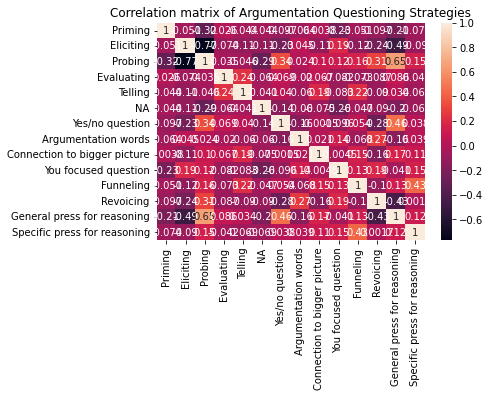

Trainer is attempting to log a value of "[0.9545454382896423, 0.8522727489471436, 0.8920454382896423, 0.9204545617103577, 0.9602272510528564, 0.9829545617103577, 0.7556818127632141, 0.9261363744735718, 0.8806818127632141, 0.9431818127632141, 0.9488636255264282, 0.8920454382896423, 0.8238636255264282, 0.8977272510528564]" of type <class 'list'> for key "eval/classwise_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "                              precision    recall  f1-score   support

                     Priming       0.00      0.00      0.00         8
                   Eliciting       0.76      0.49      0.59        39
                     Probing       0.90      0.95      0.92       119
                  Evaluating       1.00      0.12      0.22        16
                     Telling       0.00      0.00      0.00         7
                          NA       1.00      0.57

{'eval_accuracy_thresh': 0.8908278942108154,
 'eval_classwise_accuracy': [0.9545454382896423,
  0.8522727489471436,
  0.8920454382896423,
  0.9204545617103577,
  0.9602272510528564,
  0.9829545617103577,
  0.7556818127632141,
  0.9261363744735718,
  0.8806818127632141,
  0.9431818127632141,
  0.9488636255264282,
  0.8920454382896423,
  0.8238636255264282,
  0.8977272510528564],
 'eval_corr_matrix': None,
 'eval_loss': 0.26962578296661377,
 'eval_runtime': 341.5628,
 'eval_samples_per_second': 0.515,
 'eval_stats_report': '                              precision    recall  f1-score   support\n\n                     Priming       0.00      0.00      0.00         8\n                   Eliciting       0.76      0.49      0.59        39\n                     Probing       0.90      0.95      0.92       119\n                  Evaluating       1.00      0.12      0.22        16\n                     Telling       0.00      0.00      0.00         7\n                          NA       1.00     

In [41]:
trainer.evaluate()

###Predictions on New Data

In [6]:
from transformers import TextClassificationPipeline
import pandas as pd # for dataframes (loading data from csv files)
from transformers import AutoTokenizer # tokenizing data

####Load dataset

Read from CSV and remove student lines.

In [11]:
FILENAME = 'anonymized ELK data table.csv' # csv file containing dataset
df = pd.read_csv(FILENAME, header=0)

#remove student lines from the dataset
for i, role in enumerate(df['role']):
    if role != 'Teacher':
        df = df.drop(index=i)
df = df.reset_index()

####Code data

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

# create function which takes 
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# put lines into a list to use as input for classifier
lines = []
for line in df['line']: lines.append(line)

coded_data = pipe(lines)

####Save to CSV

In [16]:
# convert default config labels to argumenation codes. used to output CSV with correct column headings
ID2LABEL = {0:'Priming', 1:'Eliciting', 2:'Probing', 3:'Evaluating', 4:'Telling', 5:'NA', 6:'Yes/no question', 7:'Argumentation words', 8:'Connection to bigger picture', 9:'You focused question', 10:'Funneling', 11:'Revoicing', 12:'General press for reasoning', 13:'Specific press for reasoning'}

# add coded data to dataframe so it can be saved as a csv
for i,line in enumerate(coded_data):
  for dict_ in line:
    label_num = int(dict_['label'][6:])
    # label = dict_['label']
    score = round(dict_['score']) # round raw outputs to 0 and 1. equivalent to using a threshold of 0.5
    try:
      # df[label][i] = score
      df[ID2LABEL[label_num]][i] = score
    except:
      # create new column in dataframe with correct column heading
      new_col = [score]+(len(coded_data)-1)*['NaN']
      # df[label] = new_col
      df[ID2LABEL[label_num]] = new_col

# remove columns with incorrect names
df.drop(labels=['LABEL_'+str(i) for i in range(len(ID2LABEL.keys()))])

# rename columns 
# mapper = {'LABEL_'+str(i): ID2LABEL[i] for i in range(len(ID2LABEL.keys()))}
# df.rename(columns=mapper)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
df.to_csv('out.csv') # save dataframe to csv